# Import libraries

In [3]:
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, GroundWater, IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from pathlib import Path

# Directories

In [4]:
DataDir = Path('/home/c4ubuntu/projDir/SADC/data/04_sitefiles/') 

In [5]:
os.listdir(DataDir)

['AgERA5_Big_Bend.csv']

# Weather

In [6]:
weather = pd.read_csv(DataDir/'AgERA5_Big_Bend.csv', index_col=0, parse_dates=['Date'])

In [7]:
weather_data = weather

## Define the sites and parameters we need to model

Here we automate the modelling process. The input parameters for a given site is specified and modelled.

In [9]:
Sites = [{'Name':'Big_Bend','Soil':'SandyLoam','Crop':'SugerCane'}]

for site in Sites:
    name = site.get('Name')
    print(name)

Big_Bend


In [23]:
# Soil

sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

# Crop

maize = Crop('Maize', planting_date='10/01')
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)


# Initial water
InitWC = InitialWaterContent(value=['FC'])

# Irrigation

#net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

net_irrigation = IrrigationManagement(irrigation_method=0)


In [27]:
# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                      sim_end_time=f'{2022}/01/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=maize,
                      initial_water_content=InitWC)

# run model till termination
model.run_model(till_termination=True)

# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
#model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1980-02-10,404,11.412894,0
1,1,Maize,1981-02-10,770,12.533013,0
2,2,Maize,1982-02-10,1135,11.115747,0
3,3,Maize,1983-02-10,1500,8.331252,0
4,4,Maize,1984-02-10,1865,12.664608,0


In [25]:
out = model._outputs.final_stats

In [26]:
out

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,SugarCane,1980-04-10,464,8.403852,0
1,1,SugarCane,1981-04-10,829,8.783839,0
2,2,SugarCane,1982-04-10,1194,7.106654,0
3,3,SugarCane,1983-04-10,1559,5.028027,0
4,4,SugarCane,1984-04-10,1925,11.357315,0
5,5,SugarCane,1985-04-10,2290,11.814849,0
6,6,SugarCane,1986-04-10,2655,10.159829,0
7,7,SugarCane,1987-04-10,3020,7.232629,0
8,8,SugarCane,1988-04-10,3386,9.400726,0
9,9,SugarCane,1989-04-10,3751,8.896387,0


## Weather station data

#### Big Bend

In [297]:
weather_bb = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_554_20220920.xlsx', parse_dates=[1])
weather_bb.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_bb.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_bb = weather_bb[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]

weather_data_bb = weather_bb.dropna(how='any')

In [346]:
weather_bb

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,18.06,29.08,0.0,4.40,1979-10-31
1,17.50,30.50,0.0,3.55,1979-11-01
2,16.50,31.00,0.0,5.44,1979-11-02
3,20.50,29.80,5.0,4.82,1979-11-03
4,20.30,37.30,0.0,6.86,1979-11-04
...,...,...,...,...,...
13538,18.80,39.50,0.0,7.83,2017-02-02
13539,24.60,35.50,0.0,8.09,2017-02-03
13540,20.00,36.00,0.0,7.88,2017-02-04
13541,21.50,38.80,0.0,8.28,2017-02-05


#### Mhlume RSSC 26'10'0, 31'48'0

In [298]:
weather_mh = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_555_20220920.xlsx', parse_dates=[1])
weather_mh.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_mh.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_mh = weather_mh[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]
weather_mh = weather_mh.dropna(how='any')

In [345]:
weather_mh

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,14.59,26.55,0.0,3.47,1968-04-30
1,15.80,30.50,0.0,4.42,1968-05-01
2,9.20,30.20,0.0,3.37,1968-05-02
3,12.70,32.10,0.0,3.80,1968-05-03
4,10.00,30.40,0.0,3.62,1968-05-04
...,...,...,...,...,...
17007,18.49,30.67,0.0,4.25,2014-11-22
17008,18.24,31.15,4.5,4.56,2014-11-23
17009,18.23,30.85,0.3,6.13,2014-11-24
17010,17.06,27.39,1.6,4.85,2014-11-25


#### Simunye Mlaula 26'12'0, 31'54'0

In [299]:
weather_sm = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_553_20220920.xlsx', parse_dates=[1])
weather_sm.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_sm.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_sm = weather_sm[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]

weather_sm = weather_sm.dropna(how='any')

In [344]:
weather_sm

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,14.29,26.74,0.0,3.14,1979-04-30
1,14.11,32.60,0.0,3.96,1979-05-01
2,19.00,32.90,0.0,5.14,1979-05-02
3,18.20,33.50,0.0,6.14,1979-05-03
4,19.90,28.40,0.0,5.18,1979-05-04
...,...,...,...,...,...
13715,17.75,36.06,0.0,6.79,2017-02-02
13716,21.40,33.28,0.0,7.38,2017-02-03
13717,19.39,34.02,0.0,7.44,2017-02-04
13718,20.27,36.66,0.0,7.74,2017-02-05


# Soil

In [359]:
sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

# Crop

In [441]:
maize = Crop('Maize', planting_date='10/01')
sugercane = Crop('SugarCane', planting_date='10/1', harvest_date='04/15',PlantMethod=1 )

# Initial water

In [445]:
InitWC = InitialWaterContent(value=['SAT'])

# Irrigation

In [399]:
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

# Model

In [417]:
# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/10/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=sugercane,
                      initial_water_content=InitWC)

In [418]:
# run model till termination
model.run_model(till_termination=True)

True

In [419]:
# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
#model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,SugarCane,2000-10-01,243,13.075364,0
1,1,SugarCane,2001-08-08,554,8.541564,0
2,2,SugarCane,2002-09-22,964,8.984006,0
3,3,SugarCane,2003-08-19,1295,8.211898,0
4,4,SugarCane,2004-10-01,1704,12.969710,0


## Model different soil

In [403]:
# combine into aquacrop model and specify start and end simulation date
model_clay = AquaCropModel(sim_start_time=f'{2000}/10/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=Soil('Clay'),
                      crop=wheat,
                      initial_water_content=InitWC)

model_clay.run_model(till_termination=True)

True

In [404]:
names=['Sandy Loam','Clay']

#combine our two output files
dflist=[model._outputs.final_stats,
        model_clay._outputs.final_stats] 

outlist=[]
for i in range(len(dflist)): # go through our two output files
    temp = pd.DataFrame(dflist[i]['Yield (tonne/ha)']) # extract the seasonal yield data
    temp['label']=names[i] # add the soil type label
    outlist.append(temp) # save processed results

# combine results
all_outputs = pd.concat(outlist,axis=0)

Text(0, 0.5, 'Yield (tonne/ha)')

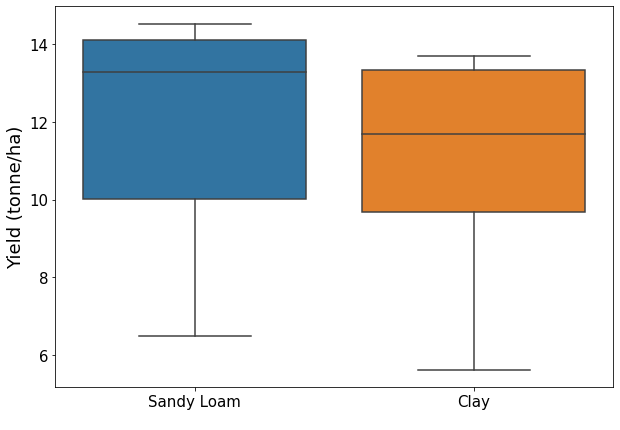

In [405]:
#create figure
fig,ax=plt.subplots(1,1,figsize=(10,7),)

# create box plot
sns.boxplot(data=all_outputs,x='label',y='Yield (tonne/ha)',ax=ax,)

# labels and font sizes
ax.tick_params(labelsize=15)
ax.set_xlabel(' ')
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)

# Model different locations

In [517]:
InitWC = InitialWaterContent(value=['FC'])

In [713]:
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

In [811]:
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)

In [812]:
sugercane = Crop('SugarCane', planting_date='10/1', harvest_date='04/10')

In [813]:
sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

In [814]:
# combine into aquacrop model and specify start and end simulation date
model_a = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=clay_loam,
                      crop=sugercane,
                     initial_water_content=InitWC)
model_a.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_bb = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_bb,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        groundwater=GroundWater(water_table='Y',
                                       dates=[f'{2000}/10/01'],
                                       values=[1]),
                        irrigation_management=net_irrigation)
model_bb.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_mh = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_mh,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_mh.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_sm = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_sm,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_sm.run_model(till_termination=True)

True

In [815]:
names=['Big Bend','Mhlume','Simunye Mlaula', 'Grid Weather']

#combine our two output files
dflist=[model_bb._outputs.final_stats,
        model_mh._outputs.final_stats, model_sm._outputs.final_stats, 
        model_a._outputs.final_stats] 

outlist=[]
for i in range(len(dflist)): # go through our two output files
    temp = pd.DataFrame(dflist[i]['Yield (tonne/ha)']) # extract the seasonal yield data
    temp['label']=names[i] # add the soil type label
    outlist.append(temp) # save processed results

# combine results
all_outputs = pd.concat(outlist,axis=0)

Text(0, 0.5, 'Yield (tonne/ha)')

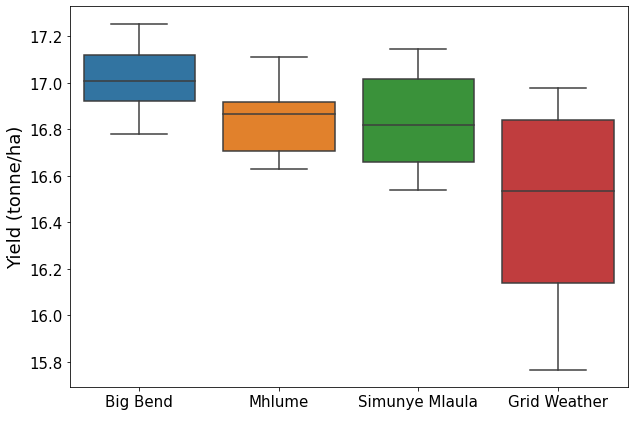

In [816]:
#create figure
fig,ax=plt.subplots(1,1,figsize=(10,7),)

# create box plot
sns.boxplot(data=all_outputs,x='label',y='Yield (tonne/ha)',ax=ax,)

# labels and font sizes
ax.tick_params(labelsize=15)
ax.set_xlabel(' ')
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)

In [804]:
model_sm._outputs.final_stats.to_excel('MS.xlsx')

In [ ]:
## Initial Water
InitWC = InitialWaterContent(value=['FC'])

##Irrigation
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

##Crop
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)
##Management


##Groundwater




# combine into aquacrop model and specify start and end simulation date
model_a = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=clay_loam,
                      crop=sugercane,
                     initial_water_content=InitWC)
model_a.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_bb = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_bb,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        groundwater=GroundWater(water_table='Y',
                                       dates=[f'{2000}/10/01'],
                                       values=[1]),
                        irrigation_management=net_irrigation)
model_bb.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_mh = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_mh,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_mh.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_sm = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_sm,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_sm.run_model(till_termination=True)

# Custom soils

In [74]:
custom = Soil('custom',cn=46,rew=7)

In [75]:
custom.add_layer(thickness=custom.zSoil,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

In [76]:
custom = Soil('custom',cn=46,rew=7)
custom.add_layer_from_texture(thickness=custom.zSoil,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

In [77]:
custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1075,0.215,0.382,0.511,136.4,100,0.48
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1075,0.215,0.382,0.511,136.4,100,0.48
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1075,0.215,0.382,0.511,136.4,100,0.48
3,3,1.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100,0.48
4,4,1.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100,0.48
5,5,1.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100,0.48
6,6,1.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100,0.48
7,7,1.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100,0.48
8,8,1.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100,0.48
9,9,1.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100,0.48


In [78]:
custom = Soil('custom',cn=46,rew=7)

custom.add_layer(thickness=0.3,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

custom.add_layer_from_texture(thickness=1.5,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
3,3,2.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
4,4,2.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
5,5,2.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
6,6,2.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
7,7,2.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
8,8,2.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
9,9,2.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100.0,0.48


# Groundwater

In [81]:
# constant groundwater depth of 2m
gw_model = AquaCropModel(sim_start_time=f'{1995}/10/01',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      initial_water_content=InitWC,            
                      groundwater=GroundWater(water_table='Y',
                                       dates=[f'{1995}/10/01'],
                                       values=[2])
                    )

In [82]:
gw_model.run_model(till_termination=True)

True

In [83]:
gw_model._outputs.final_stats

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1996-02-10,131,13.848702,0
1,1,Maize,1997-02-10,497,14.265383,0
2,2,Maize,1998-02-10,862,14.290760,0
3,3,Maize,1999-02-10,1227,14.179298,0
4,4,Maize,2000-02-10,1592,14.421791,0
5,5,Maize,2001-02-10,1958,14.339423,0
6,6,Maize,2002-02-10,2323,14.306611,0
7,7,Maize,2003-02-10,2688,14.473195,0
8,8,Maize,2004-02-10,3053,14.317730,0
9,9,Maize,2005-02-10,3419,14.510294,0


In [84]:
# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
# model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1996-02-10,131,13.688820,0
1,1,Maize,1997-02-10,497,14.279829,0
2,2,Maize,1998-02-10,862,14.284479,0
3,3,Maize,1999-02-10,1227,13.711132,0
4,4,Maize,2000-02-10,1592,14.434245,0
